<a href="https://colab.research.google.com/github/milymedina98/InteligenciaArtificial/blob/main/1neumonia_inceptionv3_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard Imports
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns # Visualization


# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"milagrosmedina","key":"4f5c9bcd8f63c233748e92ea627622b7"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [00:22<00:00, 53.1MB/s]
100% 1.17G/1.17G [00:22<00:00, 55.0MB/s]


In [ ]:
from zipfile import ZipFile
import glob

zip_file = ZipFile('/content/labeled-chest-xray-images.zip')
#opening the zip file in READ mode
with ZipFile('/content/labeled-chest-xray-images.zip', 'r') as zip:
 # extracting all the files
 print('Extracting all the files now...')
 zip.extractall()
 print('Done!')

!cd /content

Extracting all the files now...
Done!


In [ ]:
BATCH_SIZE = 64
EPOCHS = 20
base_dir = '/content/'
data_dir = os.path.join(base_dir, 'chest_xray')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
#TRAIN_PATH = 'labeled-chest-xray-images/chest_xray/train'
#TEST_PATH = 'labeled-chest-xray-images/chest_xray/test'
#path to train normal and pneumonia images
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

#path to test normal and pneumonia images
test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

#list of files names for images in train normal and pneumonia folders
TRAIN_PNEUMONIA = os.listdir(train_pneu_dir)
TRAIN_NORMAL = os.listdir(train_normal_dir)

#list of filess names for images in test normal and pneumonia folders 
TEST_PNEUMONIA = os.listdir(test_pneu_dir)
TEST_NORMAL = os.listdir(test_normal_dir)


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

In [ ]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Normal images in train-set: ', num_train_normal) 
print('Pneumonia images in train-set: ', num_train_pneumonia)
print('Total images in train-set: ', num_train,'--->', round(num_train/num_all,3)*100, 'Percent')

print("\nNormal images in test-set:", num_test_normal)
print("Pneumonia images in test-set:", num_test_pneumonia)
print('Total images in test-set: ', num_test, '--->', round(num_test/num_all,3)*100, 'Percent')

print('\nAll the images in Dataset: ', num_all)

Normal images in train-set:  1349
Pneumonia images in train-set:  3883
Total images in train-set:  5232 ---> 89.3 Percent

Normal images in test-set: 234
Pneumonia images in test-set: 390
Total images in test-set:  624 ---> 10.7 Percent

All the images in Dataset:  5856


In [ ]:
# Data-Augmentation Parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, # Randomly rotate my image between 0 and 5 degrees.
                                   width_shift_range=0.1, # Horizontal shift.
                                   height_shift_range=0.1, # Vertical shift.
                                   zoom_range=0.1, # Zoom.
                                   horizontal_flip=True, # Randomly flip inputs horizontally.
                                   samplewise_center=True, # Set each sample mean to 0. 
                                   samplewise_std_normalization=True) # Divide each input by its std.
                                   
train_generator = train_datagen.flow_from_directory(directory= train_dir, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=train_dir, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validation\Test should not be augmented.
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=test_dir, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

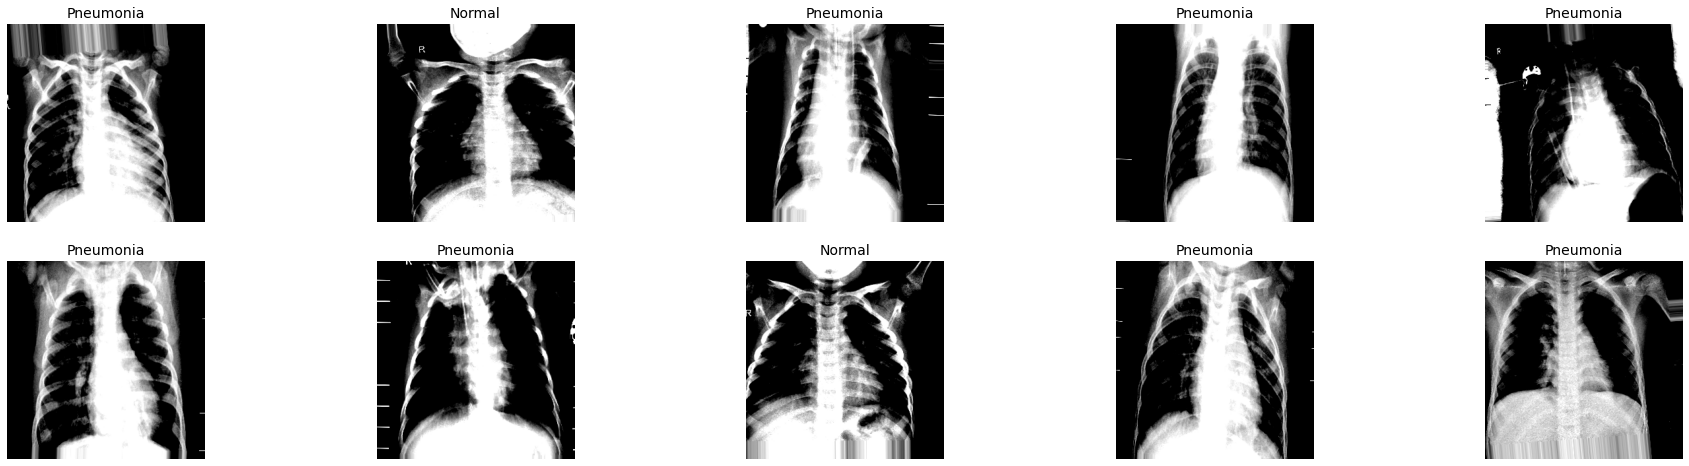

In [ ]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

In [ ]:
# InceptionV3 with Transfer Learning
def craete_model():
    
    # Load v3 model without the top layer
    inception_v3_model = InceptionV3(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)

    # Freeze
    inception_v3_model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(inception_v3_model.layers[-1].output) # Flatt last v3 layer (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=inception_v3_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

# Compile the Model
model.compile(optimizer=opt, loss=loss, metrics=[met])

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/

# From Github Gist: https://gist.github.com/hantoine/4e7c5bc6748861968e61e60bab89e9b0
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from subprocess import Popen
from os import chmod
from os.path import isfile
import json
import time
import psutil

def launch_tensorboard():
    tb_process, ngrok_process = None, None
    
    # Launch TensorBoard
    if not is_process_running('tensorboard'):
        tb_command = 'tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006'
        tb_process = run_cmd_async_unsafe(tb_command)
    
    # Install ngrok
    if not isfile('./ngrok'):
        ngrok_url = 'https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip'
        download_and_unzip(ngrok_url)
        chmod('./ngrok', 0o755)

    # Create ngrok tunnel and print its public URL
    if not is_process_running('ngrok'):
        ngrok_process = run_cmd_async_unsafe('./ngrok http 6006')
        time.sleep(1) # Waiting for ngrok to start the tunnel
    ngrok_api_res = urlopen('http://127.0.0.1:4040/api/tunnels', timeout=10)
    ngrok_api_res = json.load(ngrok_api_res)
    assert len(ngrok_api_res['tunnels']) > 0, 'ngrok tunnel not found'
    tb_public_url = ngrok_api_res['tunnels'][0]['public_url']
    print(f'TensorBoard URL: {tb_public_url}')

    return tb_process, ngrok_process


def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


def run_cmd_async_unsafe(cmd):
    return Popen(cmd, shell=True)


def is_process_running(process_name):
    running_process_names = (proc.name() for proc in psutil.process_iter())
    return process_name in running_process_names


tb_process, ngrok_process = launch_tensorboard()

TensorBoard URL: https://11596526f6f2.ngrok.io


In [ ]:
# For TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")

my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='my_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1),

                TensorBoard(log_dir=log_dir, histogram_freq=1) ]

In [ ]:
history = model.fit(train_generator, # If x is a dataset -> y should not be specified (since targets will be obtained from x).
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

print('\n*** Fit is over ***')
model.save('my_model.h5')

Epoch 1/20
66/66 [==============================] - 1286s 19s/step - loss: 0.2710 - accuracy: 0.8940 - val_loss: 0.1198 - val_accuracy: 0.9541

Epoch 00001: val_accuracy improved from -inf to 0.95407, saving model to my_model.h5
Epoch 2/20
66/66 [==============================] - 1287s 20s/step - loss: 0.1663 - accuracy: 0.9377 - val_loss: 0.0981 - val_accuracy: 0.9703

Epoch 00002: val_accuracy improved from 0.95407 to 0.97033, saving model to my_model.h5
Epoch 3/20
66/66 [==============================] - 1281s 19s/step - loss: 0.1260 - accuracy: 0.9510 - val_loss: 0.1476 - val_accuracy: 0.9388

Epoch 00003: val_accuracy did not improve from 0.97033
Epoch 4/20
66/66 [==============================] - 1263s 19s/step - loss: 0.1173 - accuracy: 0.9556 - val_loss: 0.1470 - val_accuracy: 0.9531

Epoch 00004: val_accuracy did not improve from 0.97033
Epoch 5/20
66/66 [==============================] - 1269s 19s/step - loss: 0.1021 - accuracy: 0.9635 - val_loss: 0.0814 - val_accuracy: 0.967

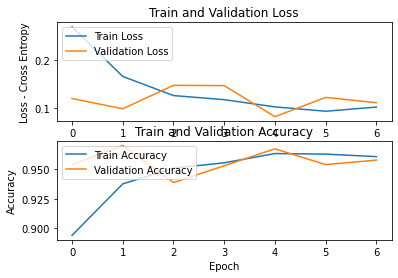

In [ ]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
test_loss = round(test_loss, 6)
test_accuracy = round(test_accuracy*100, 3)

print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

Test Loss:  0.279673
Test Accuracy:  87.019 %


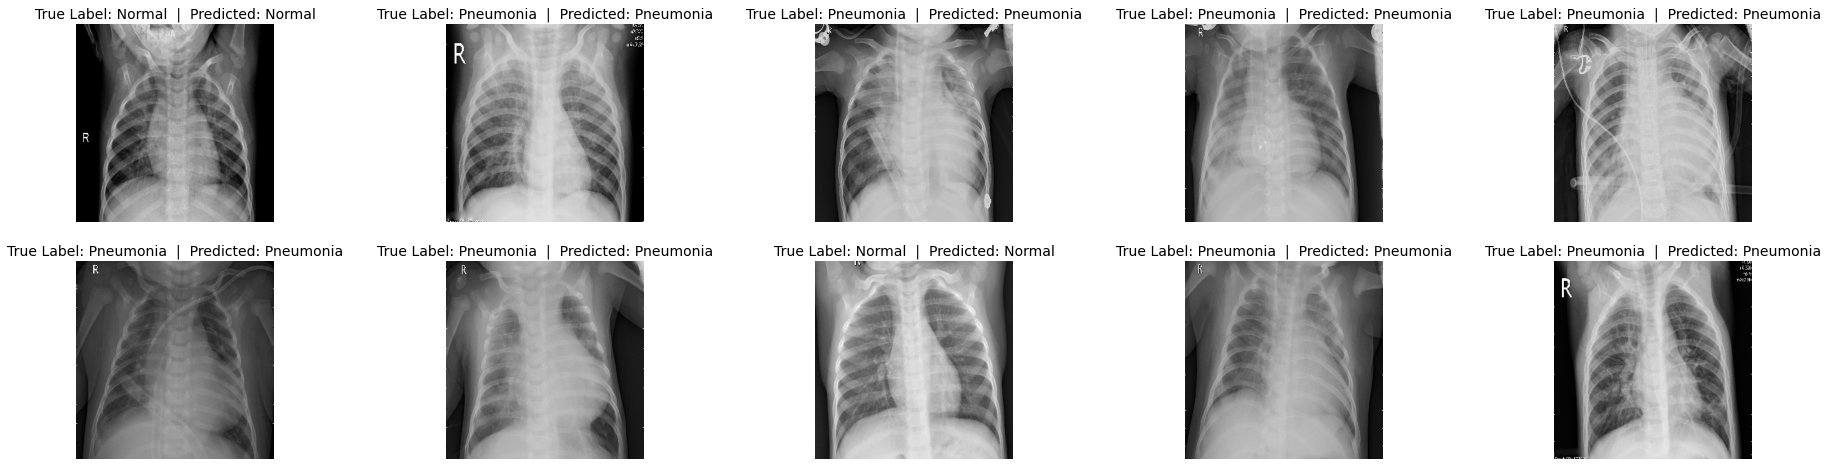

In [ ]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras_preprocessing.image import image_data_generator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:

y_pred= model.predict(test_generator).argmax(axis=-1)
y_real=test_generator.classes


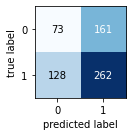

In [ ]:
matc= confusion_matrix(y_real, y_pred)
names = ['TN','FP','FN','TP']
plot_confusion_matrix(conf_mat=matc, figsize=(2,2), show_normed= False)
plt.tight_layout()
#0=normal 1=neumonia

# 16. Final Results

In [ ]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  96.35 %
Validation Accuracy:  97.03 %
Test Accuracy:  87.019 %
